# Training Keras Models to Predict HIV Inhibition from 2D Molecule Diagrams

In [1]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_absolute_error
from mordred import Calculator, descriptors
from rdkit import Chem
import pandas as pd
import numpy as np
from rdkit.Chem import AllChem
from tensorflow.keras.models import Model
from tensorflow.keras import layers, callbacks
import tensorflow as tf
from tqdm import tqdm
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [2]:
trainData = pd.read_csv('/Users/masonprr/Downloads/applied-ai-for-materials/AI-final-project/datasets/train.csv')

In [4]:
trainData = pd.DataFrame(trainData)

In [5]:
testData = pd.read_csv('/Users/masonprr/Downloads/applied-ai-for-materials/AI-final-project/datasets/test.csv')

In [6]:
validData = pd.read_csv('/Users/masonprr/Downloads/applied-ai-for-materials/AI-final-project/datasets/valid.csv')

In [7]:
def generate_image(smiles: str, size: int = 80, resolution: float = 0.5) -> np.ndarray:
    """Generate an image of a molecule with atomic information in the channels
    
    Channel 0: Atomic number of atoms
    Channel 1: Bond order
    Channel 2: Partial charges
    Channel 3: Hybridizaton of the atom
    
    Args:
        smiles: SMILES string of a molecule
        size: Size of the image
        resolution: Spatial resolution of the pixels
    Returns:
        A 4-channel image
    """

    # Parse the molecule
    mol = Chem.MolFromSmiles(smiles)
    
    # Generate the 2D coordinates of the molecule
    AllChem.Compute2DCoords(mol)
    coords = mol.GetConformer(0).GetPositions()[:, :2]  # Drop the z dimension
    
    # Center the molecule in the middle of a box
    width = size * resolution
    mean_position = coords.mean(axis=0)
    coords += width / 2 - mean_position 
    
    # Get the pixel location for each atom
    atom_pixel = np.round(coords / resolution).astype(int)
    atom_pixel = np.clip(atom_pixel, 0, size - 1)
    
    # Initialize the output image
    output = np.zeros((size, size, 4), dtype=np.float32)
    
    # Add the atom information
    mol.ComputeGasteigerCharges()
    for atom, p in zip(mol.GetAtoms(), atom_pixel):
        output[p[0], p[1], 0] = atom.GetAtomicNum()
        output[p[0], p[1], 2] = atom.GetProp("_GasteigerCharge")
        output[p[0], p[1], 3] = atom.GetHybridization().real
        
    # Add in the bonds to channel 1
    bond_channel = output[:, :, 1]
    for bond in mol.GetBonds():
        # Get the coordinates of atoms on either side of bonds
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        b_pixel = atom_pixel[bidx]
        e_pixel = atom_pixel[eidx]
        
        # Compute a path of at least the image size number of pixels in between
        frac = np.linspace(0, 1, size)
        bond_pixels = e_pixel + frac[:, None] * (b_pixel - e_pixel)
        bond_pixels = np.round(bond_pixels).astype(int)
        
        # Set all of those values to the bond type value
        btype = bond.GetBondTypeAsDouble()
        for pix in bond_pixels:
            bond_channel[pix[0], pix[1]] = btype
    return output

In [8]:
train_img = []
for smile in trainData.smiles:
    train_img.append(generate_image(smile))

In [ ]:
## Example Image

In [9]:
test_img = []
for smile in testData.smiles:
    test_img.append(generate_image(smile))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

KeyboardInterrupt: 

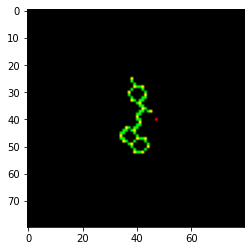

In [84]:
test0s = []
test1s = []
for i in range(10000):
    plt.imshow(test_img[i][:,:,:3])
    if(testData.HIV_active[i] == 0):
            plt.savefig(f'test_imgf/0/line_plotTest{i}.png') 
            train0s.append(i)
    else:
        if(testData.HIV_active[i] == 1):
            plt.savefig(f'test_imgf/1/line_plotTest{i}.png')
            test1s.append(i)

In [46]:
valid_img = []
for smile in validData.smiles:
    valid_img.append(generate_image(smile))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

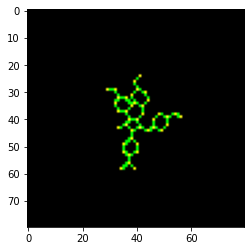

In [181]:
valid0s = []
valid1s = []
for i in range(len(valid_img)):
    plt.imshow(valid_img[i][:,:,:3])
    if(validData.HIV_active[i] == 0):
            plt.savefig(f'valid_imgf/0/line_plotValid{i}.png') 
            valid0s.append(i)
    else:
        if(validData.HIV_active[i] == 1):
            plt.savefig(f'valid_imgf/1/line_plotValid{i}.png')
            valid1s.append(i)

# Building the models

#### Model 1

In [166]:
#use the Sequential package to initialize a linear stack of layers. 
#create a classifier variable since this is a classification problem
classifier = Sequential()

In [167]:
#using 32 feature detectors, using 3x3 convolutional window shape, using 'relu' activation 
# to convert all negative vals in convolution to 0
#in effect, "decreases" the image's size
classifier.add(Conv2D(32, (3, 3), input_shape = (288, 432, 3), activation='relu', padding="same"))

#pooling step
classifier.add(MaxPooling2D(pool_size=(2,2)))

#"Flatten's" to single vector to be passed to CNN
classifier.add(Flatten())

In [168]:
classifier.add(Dense(units = 128, activation='relu'))

In [169]:
classifier.add(Dense(units=1, activation='sigmoid'))

In [170]:
classifier.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [171]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('/Users/masonprr/Downloads/applied-ai-for-materials/train_imgf', target_size=(432, 288), batch_size=32, class_mode='binary')

Found 1000 images belonging to 2 classes.


In [172]:
test_set = test_datagen.flow_from_directory('/Users/masonprr/Downloads/applied-ai-for-materials/test_imgf', target_size=(288, 432), batch_size=32, class_mode='binary')

Found 1000 images belonging to 2 classes.


#### Model 2

In [219]:
classifier2 = Sequential()
classifier2.add(Conv2D(32, (3, 3), input_shape = (288, 432, 3), activation='relu', padding="same"))
classifier2.add(MaxPooling2D(pool_size=(2,2)))
classifier2.add(Flatten())
classifier2.add(Dense(units = 128, activation='relu'))
##############EXTRA DENSE LAYER###################
classifier2.add(Dense(units=128, activation='relu'))
##################################################
classifier2.add(Dense(units=1, activation='sigmoid'))
classifier2.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
training_set2 = train_datagen.flow_from_directory('/Users/masonprr/Downloads/applied-ai-for-materials/train_imgf', target_size=(432, 288), batch_size=32, class_mode='binary')
test_set2 = test_datagen.flow_from_directory('/Users/masonprr/Downloads/applied-ai-for-materials/test_imgf', target_size=(288, 432), batch_size=32, class_mode='binary')

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Model 3

In [221]:
classifier3 = Sequential()
classifier3.add(Conv2D(32, (3, 3), input_shape = (288, 432, 3), activation='relu', padding="same"))
classifier3.add(MaxPooling2D(pool_size=(2,2)))
classifier3.add(Flatten())
classifier3.add(Dense(units = 128, activation='relu'))
##############EXTRA TWO DENSE LAYERS###################
classifier3.add(Dense(units=128, activation='relu'))
classifier3.add(Dense(units = 128, activation='relu'))
##################################################
classifier3.add(Dense(units=1, activation='sigmoid'))
classifier3.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
training_set3 = train_datagen.flow_from_directory('/Users/masonprr/Downloads/applied-ai-for-materials/train_imgf', target_size=(432, 288), batch_size=32, class_mode='binary')
test_set3 = test_datagen.flow_from_directory('/Users/masonprr/Downloads/applied-ai-for-materials/test_imgf', target_size=(288, 432), batch_size=32, class_mode='binary')

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Training

In [175]:
classifier.fit_generator(training_set, steps_per_epoch=20, epochs=20, validation_data=test_set, validation_steps=1000)

Epoch 1/20
20/20 [==============================] - 76s 4s/step - loss: 0.2156 - accuracy: 0.9464 - val_loss: 0.2151 - val_accuracy: 0.9640
Epoch 2/20
20/20 [==============================] - 57s 3s/step - loss: 0.2415 - accuracy: 0.9383
Epoch 3/20
20/20 [==============================] - 56s 3s/step - loss: 0.2378 - accuracy: 0.9422
Epoch 4/20
20/20 [==============================] - 50s 2s/step - loss: 0.2048 - accuracy: 0.9513
Epoch 5/20
20/20 [==============================] - 55s 3s/step - loss: 0.2034 - accuracy: 0.9563
Epoch 6/20
20/20 [==============================] - 64s 3s/step - loss: 0.2154 - accuracy: 0.9469
Epoch 7/20
20/20 [==============================] - 53s 3s/step - loss: 0.1763 - accuracy: 0.9578
Epoch 8/20
20/20 [==============================] - 78s 4s/step - loss: 0.1964 - accuracy: 0.9481
Epoch 9/20
20/20 [==============================] - 57s 3s/step - loss: 0.1732 - accuracy: 0.9594
Epoch 10/20
20/20 [==============================] - 64s 3s/step - loss: 0.1

In [222]:
classifier2.fit_generator(training_set2, steps_per_epoch=20, epochs=20, validation_data=test_set2, validation_steps=1000)

Epoch 1/20
20/20 [==============================] - 81s 4s/step - loss: 7.8231 - accuracy: 0.7622 - val_loss: 3.3052 - val_accuracy: 0.9640
Epoch 2/20
20/20 [==============================] - 53s 3s/step - loss: 4.4606 - accuracy: 0.8592
Epoch 3/20
20/20 [==============================] - 50s 2s/step - loss: 0.2936 - accuracy: 0.9520
Epoch 4/20
20/20 [==============================] - 48s 2s/step - loss: 0.2116 - accuracy: 0.9502
Epoch 5/20
20/20 [==============================] - 54s 3s/step - loss: 0.2356 - accuracy: 0.9397
Epoch 6/20
20/20 [==============================] - 81s 4s/step - loss: 0.1967 - accuracy: 0.9488
Epoch 7/20
20/20 [==============================] - 81s 4s/step - loss: 0.1961 - accuracy: 0.9522
Epoch 8/20
20/20 [==============================] - 81s 4s/step - loss: 0.1347 - accuracy: 0.9706
Epoch 9/20
20/20 [==============================] - 73s 4s/step - loss: 0.1735 - accuracy: 0.9607
Epoch 10/20
20/20 [==============================] - 63s 3s/step - loss: 0.2

In [223]:
classifier3.fit_generator(training_set3, steps_per_epoch=20, epochs=20, validation_data=test_set3, validation_steps=1000)

Epoch 1/20
20/20 [==============================] - 97s 5s/step - loss: 6.5996 - accuracy: 0.7388 - val_loss: 2.9877 - val_accuracy: 0.9640
Epoch 2/20
20/20 [==============================] - 48s 2s/step - loss: 1.1599 - accuracy: 0.9311
Epoch 3/20
20/20 [==============================] - 53s 2s/step - loss: 0.2070 - accuracy: 0.9500
Epoch 4/20
20/20 [==============================] - 49s 2s/step - loss: 0.1799 - accuracy: 0.9545
Epoch 5/20
20/20 [==============================] - 48s 2s/step - loss: 0.2358 - accuracy: 0.9436
Epoch 6/20
20/20 [==============================] - 46s 2s/step - loss: 0.1606 - accuracy: 0.9634
Epoch 7/20
20/20 [==============================] - 47s 2s/step - loss: 0.2101 - accuracy: 0.9440
Epoch 8/20
20/20 [==============================] - 48s 2s/step - loss: 0.2004 - accuracy: 0.9490
Epoch 9/20
20/20 [==============================] - 48s 2s/step - loss: 0.2122 - accuracy: 0.9418
Epoch 10/20
20/20 [==============================] - 49s 2s/step - loss: 0.2

# Calculating RMSE for the three models

In [183]:
from tensorflow.keras.preprocessing import image

In [225]:
sqErrsMod11 = 0
sqErrsMod10 = 0
sqErrsMod21 = 0
sqErrsMod20 = 0
sqErrsMod31 = 0
sqErrsMod30 = 0

for i in range(len(valid1s)):
    test_image = image.load_img(f'valid_imgf/1/line_plotValid{valid1s[i]}.png', target_size=(288, 432))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    prediction = classifier.predict(test_image)
    if(training_set.class_indices['1']==1):
        sqErrsMod11 += 0
    if(training_set.class_indices['1']==0):
        sqErrsMod11 += 1

for i in range(len(valid0s)):
    test_image = image.load_img(f'valid_imgf/0/line_plotValid{valid0s[i]}.png', target_size=(288, 432))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    prediction = classifier.predict(test_image)
    if(training_set.class_indices['1']==1):
        sqErrsMod10 += 1
    if(training_set.class_indices['1']==0):
        sqErrsMod10 += 0

In [226]:
for i in range(len(valid1s)):
    test_image = image.load_img(f'valid_imgf/1/line_plotValid{valid1s[i]}.png', target_size=(288, 432))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    prediction = classifier2.predict(test_image)
    if(training_set.class_indices['1']==1):
        sqErrsMod21 += 0
    if(training_set.class_indices['1']==0):
        sqErrsMod21 += 1

for i in range(len(valid0s)):
    test_image = image.load_img(f'valid_imgf/0/line_plotValid{valid0s[i]}.png', target_size=(288, 432))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    prediction = classifier2.predict(test_image)
    if(training_set.class_indices['1']==1):
        sqErrsMod20 += 1
    if(training_set.class_indices['1']==0):
        sqErrsMod20 += 0

In [227]:
for i in range(len(valid1s)):
    test_image = image.load_img(f'valid_imgf/1/line_plotValid{valid1s[i]}.png', target_size=(288, 432))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    prediction = classifier3.predict(test_image)
    if(training_set.class_indices['1']==1):
        sqErrsMod31 += 0
    if(training_set.class_indices['1']==0):
        sqErrsMod31 += 1

for i in range(len(valid0s)):
    test_image = image.load_img(f'valid_imgf/0/line_plotValid{valid0s[i]}.png', target_size=(288, 432))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    prediction = classifier3.predict(test_image)
    if(training_set.class_indices['1']==1):
        sqErrsMod30 += 1
    if(training_set.class_indices['1']==0):
        sqErrsMod30 += 0

In [228]:
model1rmse = np.sqrt((sqErrsMod11+sqErrsMod10)/1000)
print(f"Model 1's rmse is {model1rmse}")

Model 1's rmse is 0.6985699678629192


In [229]:
model2rmse = np.sqrt((sqErrsMod21+sqErrsMod20)/1000)
print(f"Model 2's rmse is {model2rmse}")

Model 2's rmse is 0.6985699678629192


In [230]:
model3rmse = np.sqrt((sqErrsMod31+sqErrsMod30)/1000)
print(f"Model 3's rmse is {model3rmse}")

Model 3's rmse is 0.6985699678629192


Text(0, 0.5, 'RMSE')

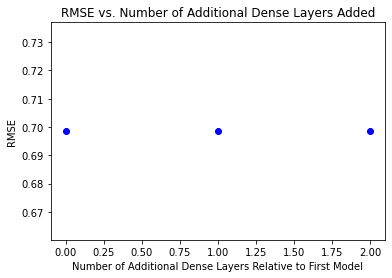

In [232]:
plt.plot([0,1,2], [model1rmse, model2rmse, model3rmse], 'bo')
plt.title('RMSE vs. Number of Additional Dense Layers Added')
plt.xlabel('Number of Additional Dense Layers Relative to First Model')
plt.ylabel('RMSE')